In [ ]:
import pandas as pd
import numpy as np
import importlib
import os
import matplotlib.pyplot as plt

import plot_fund.helper_functions as hf
import plot_fund.simulation_functions as sf
import plot_fund.scenario_analysis as sa
importlib.reload(sf)
importlib.reload(hf)
importlib.reload(sa)

from plot_fund.helper_functions import create_risk_return_plot, get_excel_sheet_names
from plot_fund.helper_functions import data_for_plotting

from plot_fund.simulation_functions import calculate_instrument_correlations, simulate_portfolio, plot_simulated_portfolio

from plot_fund.scenario_analysis import run_scenario, plot_scenario_analysis

In [80]:
file_path = 'fund.xlsx'
sheet_names = get_excel_sheet_names(file_path)
print(sheet_names)
data = pd.read_excel(file_path, sheet_name='fund_assets')
data.set_index('Strategy', inplace=True, drop=False)
data.drop('Summary', axis=0, inplace=True)
factor_corr = pd.read_excel(file_path, sheet_name='Factor_Correlation')
factor_corr.set_index('Unnamed: 0', inplace=True)

['fund_assets', 'Links', 'long_only_pms', 'Factor_Correlation']


In [81]:
# Example 1: Original plot
print("Creating original Amunra Advisors plot...")
fig1, ax1 = create_risk_return_plot(title="Ideal fund")

# Example 2: Custom data with different styling
print("Creating plot own research...")
df = data.reset_index(level='Strategy', drop=True)
plot_data = data_for_plotting(df)

fig2, ax2 = create_risk_return_plot(
    data_points=plot_data,
    title="Hypothetical Fund Analysis",
    show_arrows=False,
)

Creating original Amunra Advisors plot...


Creating plot own research...


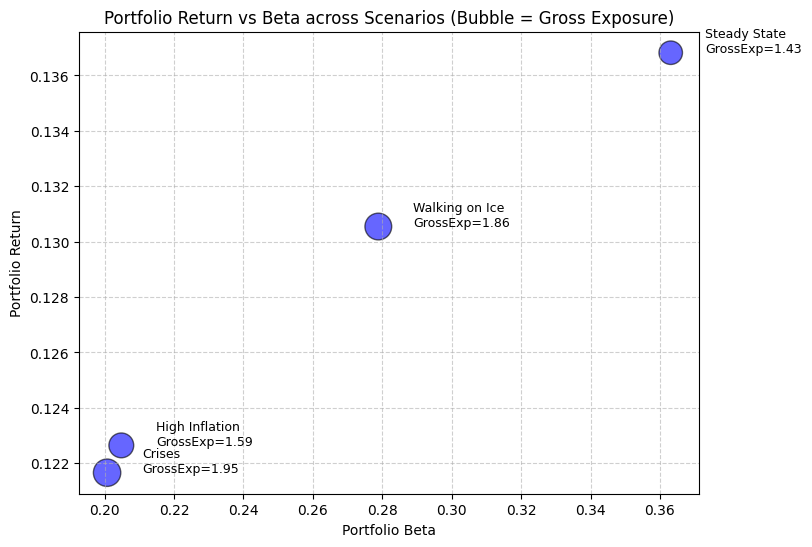

         Scenario    Return     Beta  Gross_exp
0    Steady State  0.136822  0.36310      1.430
1          Crises  0.121660  0.20070      1.945
2  High Inflation  0.122647  0.20480      1.595
3  Walking on Ice  0.130547  0.27885      1.855


In [82]:
# Define scenarios
scenarios = {
    "Steady State": {"Fixed Income +": 0.1, "Equity Long Short": 0.3, "Long Only PMS": 0.4, "Diversifiers": 0.1, "Alpha generators": 0.1},
    "Crises": {"Fixed Income +": 0.2, "Equity Long Short": 0.2, "Long Only PMS": 0.2, "Diversifiers": 0.2, "Alpha generators": 0.2},
    "High Inflation": {"Fixed Income +": 0.2, "Equity Long Short": 0.2, "Long Only PMS": 0.2, "Diversifiers": 0.3, "Alpha generators": 0.1},
    "Walking on Ice": {"Fixed Income +": 0.1, "Equity Long Short": 0.3, "Long Only PMS": 0.3, "Diversifiers": 0.1, "Alpha generators": 0.2},
}

# Beta adjustments (per strategy, per scenario)
beta_adjustments = {
    "Steady State": {"Equity Long Short": 1.0, "Long Only PMS": 1.0, "Diversifiers": 1.0, "Fixed Income +": 1.0, "Alpha generators": 1.0},
    "Crises": {"Equity Long Short": 1.1, "Long Only PMS": 1.1},
    "High Inflation": {"Equity Long Short": 0.9, "Long Only PMS": 0.9},
    "Walking on Ice": {"Equity Long Short": 1.0, "Long Only PMS": 1.1},
}

# Run the function
results_df = plot_scenario_analysis(data, scenarios, beta_adjustments)
print(results_df)

In [96]:
# Prepare data for scenario analysis
required_columns = ['Strategy', 'Fund name', 'Return_post', 'Std Dev', 'Net_exp', 'Value', 'Momentum', 'Quality', 'Risk', 'Technical']
df = data[required_columns].copy()
df.columns = ['Strategy', 'Fund name','Return_post', 'Std Dev', 'Weight', 'Value', 'Momentum', 'Quality', 'Risk', 'Technical']

# Define scenario
factor_shocks = {"Momentum": 0.05}   # Momentum -5%
asset_shocks = {"Diversifiers": 0.10, "PMS": -0.20}  # PMS down 20%, Gold +10%

# Run Scenario
results = run_scenario(df, factor_shocks, asset_shocks)

# Step 1: Replace Return_post with Scenario Returns
df_updated = data.copy()
df_updated.loc[:, "Return_post"] = results["fund_results"]["Scenario_Return"].values

# Step 2: Prepare Data for Plotting
df_updated = df_updated.reset_index(level="Strategy", drop=True)
plot_data = data_for_plotting(df_updated)

# Step 3: Create Risk-Return Plot
fig2, ax2 = create_risk_return_plot(
    data_points=plot_data,
    title="Scenario Adjusted Fund Analysis",
    show_arrows=False,
)

# Step 4: Print Results
print("\nFund-level Results (Scenario Applied):\n", results["fund_results"])
print("\nPortfolio Return (Scenario):", results["portfolio_return"])
print("Portfolio Volatility (approx):", results["portfolio_volatility"])

Diversifiers 0.1
PMS -0.2



Fund-level Results (Scenario Applied):
                           Fund name  Return_post  Scenario_Return
Strategy                                                         
Fixed Income +               Fund 1     0.072000         0.072000
Fixed Income +               Fund 2     0.064800         0.064800
Equity Long Short         AlphaGrep     0.093600         0.108600
Equity Long Short        TrueBeacon     0.115200         0.125200
Long Only PMS             MO_MidCap     0.204549         0.173639
Long Only PMS      Invesco_smallCap     0.212684         0.185147
Long Only PMS        Quant_smallcap     0.172469         0.157975
Long Only PMS           ICICI_infra     0.145128         0.136103
Diversifiers                   Gold     0.147000         0.161700
Diversifiers            Real estate     0.114660         0.126126
Alpha generators        Deriv_strat     0.120960         0.135960

Portfolio Return (Scenario): 0.133226119692
Portfolio Volatility (approx): 0.1140825


In [57]:
factor_names = factor_corr.columns.tolist()
factor_beta = data[factor_names].T

instrument_corr = calculate_instrument_correlations(factor_corr, factor_beta)
instrument_corr

Strategy           Fixed Income +  Fixed Income +  Equity Long Short  \
Strategy                                                               
Fixed Income +              1.000           0.909              0.211   
Fixed Income +              0.909           1.000              0.410   
Equity Long Short           0.211           0.410              1.000   
Equity Long Short           0.530           0.677              0.926   
Long Only PMS               0.577           0.804              0.749   
Long Only PMS               0.461           0.685              0.852   
Long Only PMS               0.398           0.613              0.934   
Long Only PMS               0.398           0.613              0.934   
Diversifiers                0.248          -0.174             -0.434   
Diversifiers                0.248          -0.174             -0.434   
Alpha generators           -0.015           0.083              0.896   

Strategy           Equity Long Short  Long Only PMS  Long Only PMS  \
Strategy                                                             
Fixed Income +                 0.530          0.577          0.461   
Fixed Income +                 0.677          0.804          0.685   
Equity Long Short              0.926          0.749          0.852   
Equity Long Short              1.000          0.899          0.946   
Long Only PMS                  0.899          1.000          0.977   
Long Only PMS                  0.946          0.977          1.000   
Long Only PMS                  0.974          0.929          0.982   
Long Only PMS                  0.974          0.929          0.982   
Diversifiers                  -0.328         -0.536         -0.534   
Diversifiers                  -0.328         -0.536         -0.534   
Alpha generators               0.712          0.387          0.540   

Strategy           Long Only PMS  Long Only PMS  Diversifiers  Diversifiers  \
Strategy                                                                      
Fixed Income +             0.398          0.398         0.248         0.248   
Fixed Income +             0.613          0.613        -0.174        -0.174   
Equity Long Short          0.934          0.934        -0.434        -0.434   
Equity Long Short          0.974          0.974        -0.328        -0.328   
Long Only PMS              0.929          0.929        -0.536        -0.536   
Long Only PMS              0.982          0.982        -0.534        -0.534   
Long Only PMS              1.000          1.000        -0.498        -0.498   
Long Only PMS              1.000          1.000        -0.498        -0.498   
Diversifiers              -0.498         -0.498         1.000         1.000   
Diversifiers              -0.498         -0.498         1.000         1.000   
Alpha generators           0.689          0.689        -0.175        -0.175   

Strategy           Alpha generators  
Strategy                             
Fixed Income +               -0.015  
Fixed Income +                0.083  
Equity Long Short             0.896  
Equity Long Short             0.712  
Long Only PMS                 0.387  
Long Only PMS                 0.540  
Long Only PMS                 0.689  
Long Only PMS                 0.689  
Diversifiers                 -0.175  
Diversifiers                 -0.175  
Alpha generators              1.000

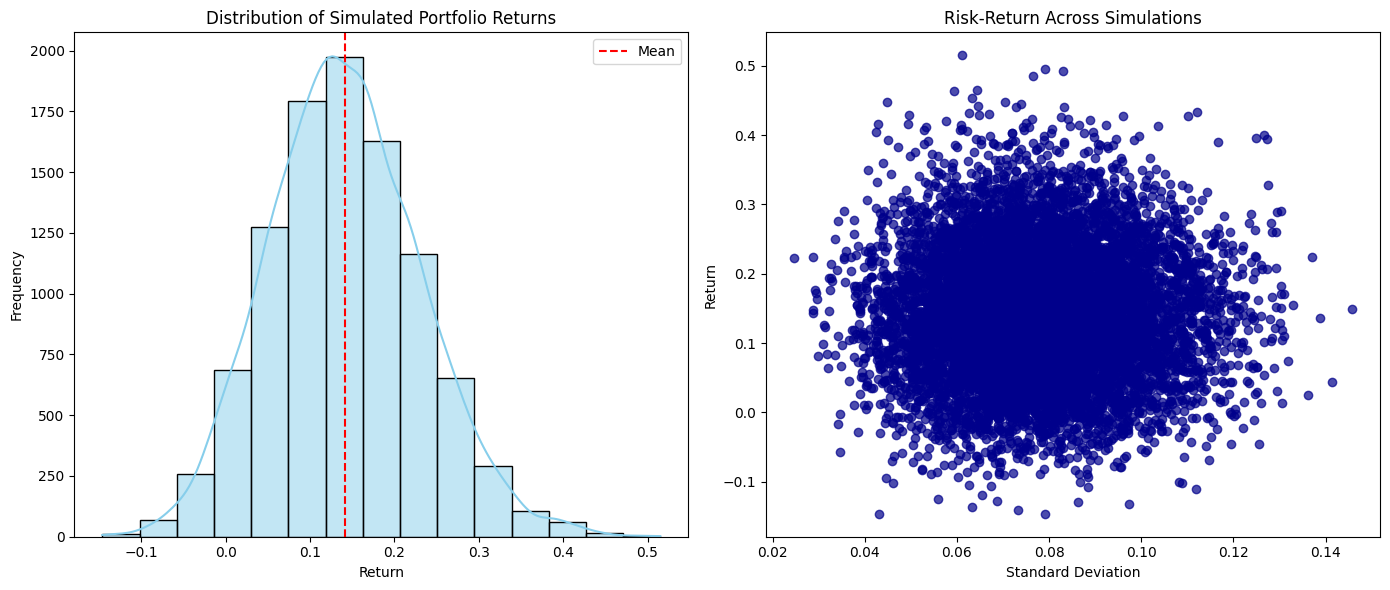

Average Portfolio Return: 0.1411970220412575
Average Portfolio StdDev: 0.07764124966071653


Simulated_Return  Simulated_StdDev
0             0.103884          0.069712
1             0.096044          0.076135
2             0.092957          0.049894
3             0.073149          0.093275
4             0.195068          0.050777
...                ...               ...
9995          0.085533          0.070398
9996          0.075310          0.063078
9997          0.085815          0.050556
9998          0.191449          0.085557
9999          0.148908          0.076090

[10000 rows x 2 columns]

In [97]:
mu = data["Return_post"]
sigma = data["Std Dev"]
corr_matrix = instrument_corr
weights = data["Net_exp"]
returns = simulate_portfolio(mu, sigma, corr_matrix, weights, n_scenarios=10000)
plot_simulated_portfolio(returns)